In [1]:
import argparse
import torch
import torchvision
from torchvision.datasets import STL10, ImageFolder, CIFAR10, CIFAR100
from solo.data.pretrain_dataloader import dataset_with_index
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import transforms
from transformers import pipeline
import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os
from transformers import Owlv2Processor, Owlv2ForObjectDetection, Owlv2ImageProcessor
from PIL import ImageDraw
import numpy as np
from IPython.display import Image 

MEANS_N_STD = {
    "cifar10": ((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    "cifar100": ((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
    "stl10": ((0.4914, 0.4823, 0.4466), (0.247, 0.243, 0.261)),
    "imagenet100": (IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    "imagenet": (IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
}

/home/AD/ofsk222/miniconda3/envs/solo-learn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data_path = f"datasets/stl10"
dataset = "stl10"
download = True

mean, std = MEANS_N_STD[dataset]
augmentations = []
augmentations.append(transforms.ToTensor())
augmentations.append(transforms.ToPILImage())
augmentations = transforms.Compose(augmentations)
augmentations = augmentations if augmentations != [] else None

train_dataset = dataset_with_index(STL10)(
    train_data_path,
    split="train+unlabeled",
    download=download,
    transform=augmentations,
)

Files already downloaded and verified


In [11]:
augmentation_error_names = [
    'rcc_i', 'rcc_j', 'rcc_h', 'rcc_w',
    'cj_brightness', 'cj_contrast', 'cj_saturation', 'cj_hue',
    'gb_sigma',
    'equalization',
    'solarization',
    'random_gray_scale',
    'random_horizontal_flip'
]

# load csv file
# adjusted color_jitters
#df = pd.read_csv("trained_models/daisy/yh0mln62/daisy_final_stl10_info.csv")

df = pd.read_csv("stl10_preprocessed_info.csv")

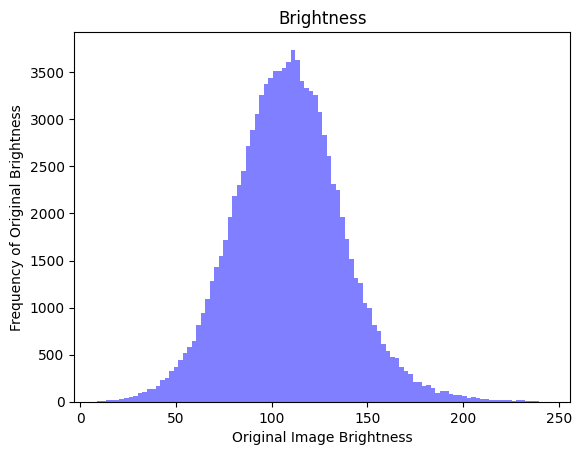

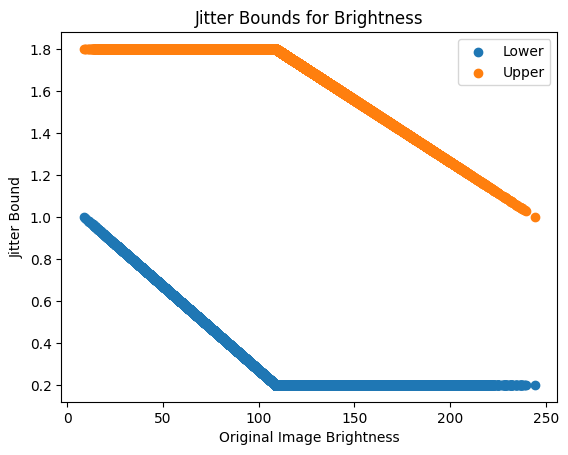

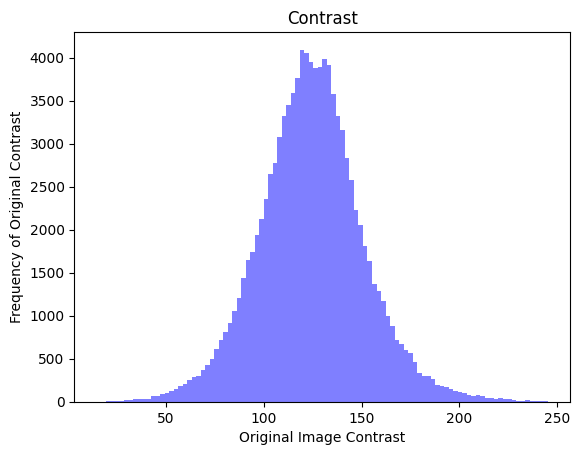

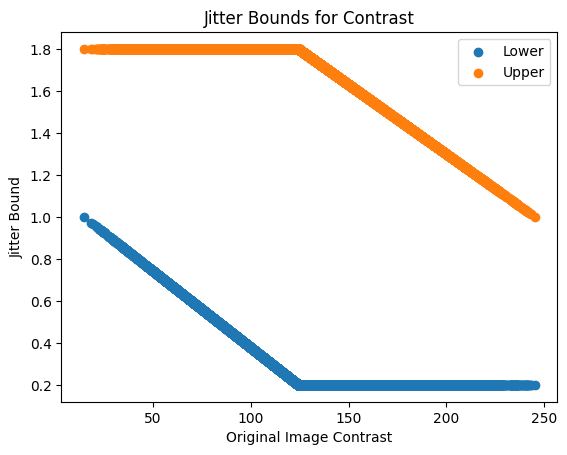

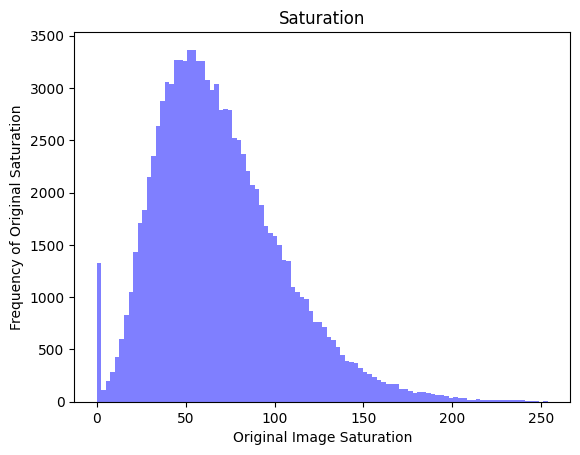

array([  0.        ,   2.53770399,   5.07540799,   7.61311198,
        10.15081597,  12.68851997,  15.22622396,  17.76392795,
        20.30163194,  22.83933594,  25.37703993,  27.91474392,
        30.45244792,  32.99015191,  35.5278559 ,  38.0655599 ,
        40.60326389,  43.14096788,  45.67867187,  48.21637587,
        50.75407986,  53.29178385,  55.82948785,  58.36719184,
        60.90489583,  63.44259983,  65.98030382,  68.51800781,
        71.05571181,  73.5934158 ,  76.13111979,  78.66882378,
        81.20652778,  83.74423177,  86.28193576,  88.81963976,
        91.35734375,  93.89504774,  96.43275174,  98.97045573,
       101.50815972, 104.04586372, 106.58356771, 109.1212717 ,
       111.65897569, 114.19667969, 116.73438368, 119.27208767,
       121.80979167, 124.34749566, 126.88519965, 129.42290365,
       131.96060764, 134.49831163, 137.03601563, 139.57371962,
       142.11142361, 144.6491276 , 147.1868316 , 149.72453559,
       152.26223958, 154.79994358, 157.33764757, 159.87

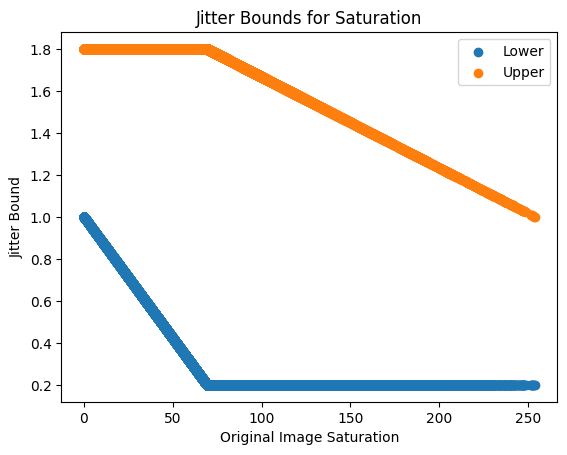

In [13]:
def make_plot_for_attribute(attribute):
    # make histogram of brightness values and errors with shared x-axis
    fig, ax1 = plt.subplots()
    camelcase_attribute = attribute.capitalize()

    # brightness
    counts, bins, _ = ax1.hist(df[f'{attribute}'], bins=100, alpha=0.5, color='blue')
    ax1.set_title(camelcase_attribute)
    ax1.set_ylabel(f'Frequency of Original {camelcase_attribute}')
    ax1.set_xlabel(f'Original Image {camelcase_attribute}')

    # for each bin, calculate average number of errors
    # error_bins = []
    # for i in range(len(bins)-1):
    #     bin_start = bins[i]
    #     bin_end = bins[i+1]
        
    #     indices_in_bin = df[(df[f'{attribute}'] >= bin_start) & (df[f'{attribute}'] < bin_end)].index
    #     errors_in_bin = np.abs(df.iloc[indices_in_bin][f'cj_{attribute}'].mean())

    #     number_steps = (0.8 - df.iloc[indices_in_bin][f'cj_{attribute}_upper_bound']).mean()

    #     error_bins.append(errors_in_bin)

    # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    # ax2.hist(bins[:-1], bins=bins, weights=error_bins, alpha=0.5, color='red')
    # ax2.tick_params(axis='y', labelcolor='tab:red')

    # ax2.set_ylabel(f'Average Change to {camelcase_attribute} Augmentation')
    plt.show()


    # make plot showing the upper and lower bounds for the given attribute
    plt.scatter(df[attribute], df[f'cj_{attribute}_lower_bound'], label="Lower")
    plt.scatter(df[attribute], df[f'cj_{attribute}_upper_bound'], label="Upper")
    plt.xlabel(f'Original Image {camelcase_attribute}')
    plt.ylabel(f'Jitter Bound')
    plt.title(f'Jitter Bounds for {camelcase_attribute}')
    plt.legend()

    return bins

make_plot_for_attribute('brightness')
make_plot_for_attribute('contrast')
make_plot_for_attribute('saturation')


In [1]:
def plot_extrema_images(attribute):
    # gets images with lowest attribue
    if attribute == 'brightness':
        indices = np.argsort(brightnesses)
    elif attribute == 'contrast':
        indices = np.argsort(contrasts)
    elif attribute == 'saturation':
        indices = np.argsort(saturations)
    
    # filter out grayscale indices
    print(len(indices))
    indices = [i for i in indices if df.iloc[i][f'is_grey_scale'] == False]
    print(len(indices))
    lowest_images = [torchvision.transforms.functional.pil_to_tensor(train_dataset[i][1]) for i in indices[:9]]
    highest_images = [torchvision.transforms.functional.pil_to_tensor(train_dataset[i][1]) for i in indices[-9:]]

    lowest_grid = torchvision.utils.make_grid(lowest_images, scale_each=True, padding=2, nrow=3)
    highest_grid = torchvision.utils.make_grid(highest_images, scale_each=True, padding=2,  nrow=3)

    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].imshow(lowest_grid.permute(1, 2, 0))
    axs[0].set_title(f'Images with Lowest {attribute}')
    axs[0].axis('off')

    axs[1].imshow(highest_grid.permute(1, 2, 0))
    axs[1].set_title(f'Images with Highest {attribute}')
    axs[1].axis('off')

    fig = plt.gcf()
    fig.set_size_inches(18, 18)
    plt.show()

plot_extrema_images('brightness')
plot_extrema_images('contrast')
plot_extrema_images('saturation')

NameError: name 'np' is not defined

In [ ]:
df.iloc[i][f'is_grey_scale']

False